## Parts of Speech Tagging 

### Comparison of Methods

Let's compare different Parts-Of-Speech (POS) taggers. Python has some popular libraries for Natural Language Processing:

- NLTK

- spaCy

- fastText

- gensim

Using the Treebank tagged corpus in the NLTK library, we'll compare the accuracy for some of NLTK's and spaCy's taggers, as well as a simple bidirectional LSTM trained using Keras, with a Tensorflow backend on a Google Colab instance.

### Libraries

In [1]:
import random
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

from keras import backend as K
from keras.engine import Layer
from keras.layers import (Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, 
                          Embedding, Activation)
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.utils import multi_gpu_model

import nltk
from nltk import ConfusionMatrix
from nltk.corpus import treebank, treebank_chunk
from nltk.tag import (UnigramTagger, BigramTagger, RegexpTagger, DefaultTagger,  
                      PerceptronTagger)

from sklearn.model_selection import train_test_split

import spacy

import tensorflow as tf
import tensorflow_hub as hub

from utils_pos_tagging import (compare_taggers, get_tag_list, apply_tagger, get_performance_dataframe,
                               get_spacy_test_sentences, get_spacy_accuracy, flatten_tagged_sentences,
                               get_word2index, get_tag2index, sentence2int, tag2int, one_hot_encoding)

from IPython.display import display

Using TensorFlow backend.


In [2]:
nltk.download('tagsets')
nltk.download('treebank')
nltk.download('maxent_treebank_pos_tagger')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package tagsets to /Users/Matt/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package treebank to /Users/Matt/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /Users/Matt/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Matt/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Penn Treebank Documentation

>[ PENN TREEBANK SAMPLE ]
http://www.cis.upenn.edu/~treebank/home.html

>This is a ~5% fragment of Penn Treebank, (C) LDC 1995.  It is made
available under fair use for the purposes of illustrating NLTK tools
for tokenizing, tagging, chunking and parsing.  This data is for
non-commercial use only.

In [3]:
tagged_sentences = treebank.tagged_sents()
print(random.choice(tagged_sentences))
print("Tagged sentences:", len(tagged_sentences))
print("Tagged words:", len(treebank.tagged_words()))

[('``', '``'), ('The', 'DT'), ('real', 'JJ'), ('difference', 'NN'), ('seems', 'VBZ'), ('*-1', '-NONE-'), ('to', 'TO'), ('be', 'VB'), ('that', 'IN'), ('the', 'DT'), ('cash', 'NN'), ('market', 'NN'), ('here', 'RB'), ('...', ':'), ('is', 'VBZ'), ('big', 'JJ'), ('enough', 'RB'), ('*RNR*-2', '-NONE-'), ('and', 'CC'), ('liquid', 'NN'), ('enough', 'RB'), ('*RNR*-2', '-NONE-'), ('that', 'IN'), ('the', 'DT'), ('futures', 'NNS'), ('market', 'NN'), ('is', 'VBZ'), ("n't", 'RB'), ('having', 'VBG'), ('the', 'DT'), ('same', 'JJ'), ('impact', 'NN'), ('0', '-NONE-'), ('it', 'PRP'), ('does', 'VBZ'), ('*?*', '-NONE-'), ('*T*-3', '-NONE-'), ('in', 'IN'), ('America', 'NNP'), ('.', '.'), ("''", "''")]
Tagged sentences: 3914
Tagged words: 100676


In [4]:
# tag raw count
tag_list = list()
for s in tagged_sentences:
    tag_list.extend([i[1] for i in s])
pd.Series(Counter(tag_list)).sort_values(ascending=False).head(10)

NN        13166
IN         9857
NNP        9410
DT         8165
-NONE-     6592
NNS        6047
JJ         5834
,          4886
.          3874
CD         3546
dtype: int64

//anaconda/envs/streetbees/lib/python3.6/site-packages/nltk/tokenize/regexp.py:130: FutureWarning: split() requires a non-empty pattern match.
  return [tok for tok in self._regexp.split(text) if tok]


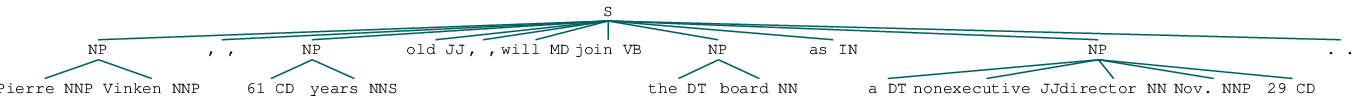

In [5]:
# visualisation
display(treebank_chunk.chunked_sents()[0])

## NLTK taggers

The following built in taggers are tested:

- `RegexpTagger`

- `DefaultTagger`

- `UnigramTagger`

- `BigramTagger`

- `PerceptronTagger`

In [6]:
# Keeping it simple for now, 80:20 train/test split without random sampling
split = int(len(tagged_sentences)*0.2)
train_sentences = tagged_sentences[split:]
test_sentences = tagged_sentences[:split]

In [7]:
# some regex patterns from NLTK documentation
patterns = [
    (r'.*ing$', 'VBG'),               # gerunds
    (r'.*ed$', 'VBD'),                # simple past
    (r'.*es$', 'VBZ'),                # 3rd singular present
    (r'.*ould$', 'MD'),               # modals
    (r'.*s$', 'NNS'),                 # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'),  # cardinal numbers
    (r'.*able$', 'JJ'),               # adjectives
    (r'.*ly$', 'RB'),                 # adverbs
    (r'.*', 'NN')                     # nouns
]

In [8]:
%timeit regexp_tagger = RegexpTagger(patterns)

6.81 µs ± 250 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [9]:
%timeit default_tagger = DefaultTagger('NN') # majority tag by inspection above

794 ns ± 19.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [10]:
%timeit unigram_tagger = UnigramTagger(train_sentences)

1.81 s ± 44.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit bigram_tagger = BigramTagger(train_sentences)

2.04 s ± 47.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit -r 3
perceptron_tagger = PerceptronTagger()
perceptron_tagger.train(train_sentences)

19.4 s ± 1.36 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [13]:
# training set only
regexp_tagger = RegexpTagger(patterns)
default_tagger = DefaultTagger('NN') # majority tag by inspection above
unigram_tagger = UnigramTagger(train_sentences)
bigram_tagger = BigramTagger(train_sentences)
perceptron_tagger = PerceptronTagger()
perceptron_tagger.train(train_sentences)

## Test set evaluation of NLTK taggers 

### Accuracy

In [14]:
tagger_dict = {
    'RegExpTagger': regexp_tagger,
    'DefaultTagger': default_tagger,
    'UnigramTagger': unigram_tagger,
    'BigramTagger': bigram_tagger,
    'PerceptronTagger': perceptron_tagger
}
compare_df = compare_taggers(tagger_dict, test_sentences)

//anaconda/envs/streetbees/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/streetbees/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
compare_df.sort_values(['Accuracy', 'F1'], ascending=False)

,Accuracy,F1,Precision,Recall
PerceptronTagger,0.965131,0.964966,0.965363,0.965131
UnigramTagger,0.840451,0.853554,0.901197,0.840451
RegExpTagger,0.220020,0.127380,0.179654,0.220020
BigramTagger,0.186124,0.217920,0.908818,0.186124
DefaultTagger,0.127189,0.028703,0.016177,0.127189


PerceptronTagger **per-token accuracy** on the test set at 0.966 approaches the generally reported 97% figures [1] for state of the art machine learning POS tagging. It may be possible to push the metric further up if the entire Treebank corpus were available to expand the training set, instead of the current ~5% subset, but with diminishing returns of performance gain.

It is important to note that a per-token accuracy metric does not reflect adequately the quality of tagging on a sentence level. [2]

[1] https://aclweb.org/aclwiki/POS_Tagging_(State_of_the_art)

[2] https://nlp.stanford.edu/pubs/CICLing2011-manning-tagging.pdf

### Confusion Matrix

In [16]:
# Picking the best performing PerceptronTagger as example
truth = get_tag_list(test_sentences)
preds = get_tag_list(apply_tagger(perceptron_tagger, test_sentences))
confusion_matrix = ConfusionMatrix(truth, preds)

print(confusion_matrix.pretty_format(show_percents=True, truncate=10, sort_by_count=True))

       |                                  -                                    |
       |                                  N                                    |
       |                                  O                                    |
       |             N                    N             N                    V |
       |      N      N      I      D      E      J      N                    B |
       |      N      P      N      T      -      J      S      ,      .      D |
-------+-----------------------------------------------------------------------+
    NN | <12.1%>  0.1%   0.0%   0.0%      .   0.3%   0.0%      .      .   0.0% |
   NNP |   0.1%  <9.8%>     .   0.0%      .   0.1%   0.0%      .      .      . |
    IN |      .      .  <9.9%>  0.0%      .   0.0%      .      .      .      . |
    DT |   0.0%      .   0.0%  <8.3%>     .      .      .      .      .      . |
-NONE- |      .      .      .      .  <6.4%>     .      .      .      .      . |
    JJ |   0.4%   0.1%   0.0

We can also look at the individual metrics for each tag to give a finer grained picture over the weighted average metrics for Precision, Recall and F1-Score calculated above.

In [17]:
test_tag_list = list()
for s in test_sentences:
    test_tag_list.extend([(i[0], i[1]) for i in s])

In [18]:
# again using the perception tagger as an example
# precision, recall, f1 scores for each individual class
print('perceptron_tagger')
get_performance_dataframe(perceptron_tagger, test_tag_list)

perceptron_tagger


,F1,Precision,Recall
NNP,0.816052,0.966690,0.706031
",",0.999450,1.000000,0.998901
CD,0.969416,0.977570,0.961397
NNS,0.921844,0.874525,0.974576
JJ,0.764623,0.887079,0.671875
MD,1.000000,1.000000,1.000000
NN,0.772423,0.639873,0.974235
DT,0.991970,0.993197,0.990746
IN,0.955495,0.921727,0.991833
.,1.000000,1.000000,1.000000


## spaCy tagger: pretrained ConvNet

Loading up `en_core_web_sm` and `en_core_web_md` models for spaCy to use for the POS tagger. 

From documentation about these models:

> English multi-task CNN trained on OntoNotes, with GloVe vectors trained on Common Crawl. Assigns word vectors, context-specific token vectors, POS tags, dependency parse and named entities.

> OntoNotes Release 5.0 is the final release of the OntoNotes project, a collaborative effort between BBN Technologies, the University of Colorado, the University of Pennsylvania and the University of Southern Californias Information Sciences Institute. The goal of the project was to annotate a large corpus comprising various genres of text (news, conversational telephone speech, weblogs, usenet newsgroups, broadcast, talk shows) in three languages (English, Chinese, and Arabic) with structural information (syntax and predicate argument structure) and shallow semantics (word sense linked to an ontology and coreference).

> Common Crawl's web archive consists of petabytes of data collected since 2011. It completes crawls generally every month.

In [19]:
# small model
sm_nlp = spacy.load('en_core_web_sm')
# medium model
md_nlp = spacy.load('en_core_web_md')

In [20]:
# inspecting top tags using small model
sm_doc = sm_nlp(' '.join([i[0] for i in test_tag_list]))
pd.Series(Counter([token.tag_ for token in sm_doc])).sort_values(ascending=False).head(10)

NN     2894
NNP    2117
IN     2109
DT     1612
NFP    1384
NNS    1203
JJ     1164
,       912
.       807
CD      691
dtype: int64

spaCy's pipeline takes care of tokenisation and parsing. However, the results of its tokenisation are different from that of NLTK's, so to arrive at an accuracy figure we can't do a straightforward plug-in to the evaluation functions written for NLTK's taggers.

In [21]:
print('Number of elements from NLTK tokenisation:', len(test_tag_list)) 
print('Number of elements from spaCy:', len([(token.text, token.tag_) for token in sm_doc]))

Number of elements from NLTK tokenisation: 19530
Number of elements from spaCy: 20876


In [22]:
spacy_test_sentences = get_spacy_test_sentences(test_sentences)

### Accuracy for spaCy tagger

In [23]:
print("small model accuracy:", get_spacy_accuracy(sm_nlp, spacy_test_sentences))
print("medium model accuracy:", get_spacy_accuracy(md_nlp, spacy_test_sentences))

small model accuracy: 89.5289298515105
medium model accuracy: 89.42140296979007


At first glance, it looks as though the accuracy score for spaCy's pretrained small and medium ConvNet English POS tagger models are both poorer than the PerceptronTagger of NLTK when evaluated on the same test sentences.

**However** this should not immediately be interpreted as the spaCy tagger having poorer performance, because there is a difference in the set of Treebank tags by NLTK and spaCy:

In [24]:
# set difference of NLTK Treebank tags and spaCy Treebank tags
set(tag_list) - set([token.tag_ for token in sm_doc])

{'#', '-NONE-', '-RRB-', 'LS'}

For this task, since the gold reference of tags is according to NLTK, spaCy's tagging will necessarily be judged 'incorrect' whenever these 4 tags are applied. Therefore no conclusion should be drawn as yet to the relative performances of NLTK and spaCy's taggers; more work needs to be done to ensure any comparison is made on an even footing.

## Bidirectional LSTM

No transfer learning applied for now. A logical next step improve the model would be to put in a pretrained Elmo embedding layer which would reduce the number of parameters that need to be trained, and only a small number left trainable for fine tuning. Some other transfer learning method using Bert / ULMFiT would also be viable.

###  Data Munging

In [25]:
# tagged_sentences = treebank.tagged_sents()
sentences, sentence_tags = flatten_tagged_sentences(tagged_sentences)
# 80:20 split
train_sentences, test_sentences, train_tags, test_tags = \
                train_test_split(sentences, sentence_tags, test_size=0.2, random_state=42)

In [26]:
# convert to integers
word2index = get_word2index(train_sentences)
tag2index = get_tag2index(train_tags)
train_sentences_X = sentence2int(train_sentences, word2index)
test_sentences_X = sentence2int(test_sentences, word2index)
train_tags_y = tag2int(train_tags, tag2index)
test_tags_y = tag2int(test_tags, tag2index)

In [27]:
# Pad sequences to maximum length of training sentences to give fixed size
MAX_LENGTH = len(max(train_sentences_X, key=len))
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

In [28]:
train_tags_y_categorical = one_hot_encoding(train_tags_y, len(tag2index))
test_tags_y_categorical = one_hot_encoding(test_tags_y, len(tag2index))

### Model building

Let's build a bidirectional LSTM, no hyperparameter tuning and no transfer learning.

Can you spot if this model is appropriate for the task at hand?

In [29]:
def build_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(MAX_LENGTH, )))
    model.add(Embedding(len(word2index), 64))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(TimeDistributed(Dense(len(tag2index))))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])

    model.summary()
    return model

In [16]:
model = build_model()
model.fit(train_sentences_X, 
          train_tags_y_categorical,
          batch_size=64, epochs=20, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 271, 64)           648960    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 271, 256)          197632    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 271, 47)           12079     
_________________________________________________________________
activation_3 (Activation)    (None, 271, 47)           0         
Total params: 858,671
Trainable params: 858,671
Non-trainable params: 0
_________________________________________________________________
Train on 2504 samples, validate on 627 samples
Epoch 1/20
2504/2504 [==============================] - 44s 18ms/step - loss: 1.1551 - acc: 0.8829 - val_loss: 0.3612 - val_acc: 0.9059
Epoch 2/20
2504/2504 [==============================] - 43s 17ms/step - loss: 0.3296 

In [0]:
# model.save('colab_trained_lstm.h5')

In [18]:
scores = model.evaluate(test_sentences_X, 
                        test_tags_y_categorical)
print("{}: {}".format(model.metrics_names[1], scores[1]))

783/783 [==============================] - 9s 12ms/step
acc: 0.987850676475


### Discussion

The above model was trained on a GPU instance with Google Colab. The exceptionally high accuracy score beyond the reported state of the art would suggest overfitting, even though the performance evaluation is done on an unseen set.

This can readily be explained by the size of the dataset:

- Tagged sentences: 3914

- Tagged words: 100676

which is very small, versus the massive learning capacity of the bidirectional LSTM with 197632 parameters.

As a general point, some measures can be taken to minimise the chances of overfitting:

- specifying a smaller network to reduce capacity of learning

- weight regularisation

- dropout

- early stopping